# Dako Titanic-datan analysointia

### Importoidaan kirjastoja

In [651]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns



### Luetaan data

In [652]:
train_set = pd.read_csv("./train.csv")
test_set = pd.read_csv("./test.csv")

In [653]:
train_set.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [654]:
test_set.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### Tarkastellaan dataa

In [655]:
print('\nNull Values in Training \n{}'.format(train_set.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_set.isnull().sum()))

print('\nDuplicated values in train {}'.format(train_set.duplicated().sum()))
print('Duplicated values in test {}'.format(test_set.duplicated().sum()))


Null Values in Training 
survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Null Values in Testing 
pclass        0
name          0
sex           0
age          86
sibsp         0
parch         0
ticket        0
fare          1
cabin       327
embarked      0
dtype: int64

Duplicated values in train 0
Duplicated values in test 0


### Muuttujat:

- passenger id = id
- survived = hengissäselviäminen (1 jos on selvinnyt, 0 jos ei)
- pclass = matkustajaluokka (1-3)
- age = ikä
- sipsb = sisarusten ja puolisoiden määrä laivalla
- parch = vanhempien ja lasten määrä laivalla
- ticket = lipun numero
- fare = lipun hinta
- cabin = hyttinumero
- embarked = kyytiinnoususatama (Q = Queenstown, S = Southampton, C = Cherbourg)

### Huomioita datasta:
- Usean matkustajan tiedoista puuttuu ikä, korvataan siis iät matkustajien mediaani-iällä.
- Yksi fare ja kaksi embark-arvoa puuttuu. Nämä korvataan yleisimmillä arvoilla kyseisissä luokissa.
- Yli 900 matkustajan tiedoista puuttuu cabin-value, joten se voidaan jättää kokonaan laskuista.
- Pudotetaan myös muut selviytymisen kannalta epäoleelliset tiedot (name, ticket)

## Visualisoidaan dataa

### Attribute histogram plots

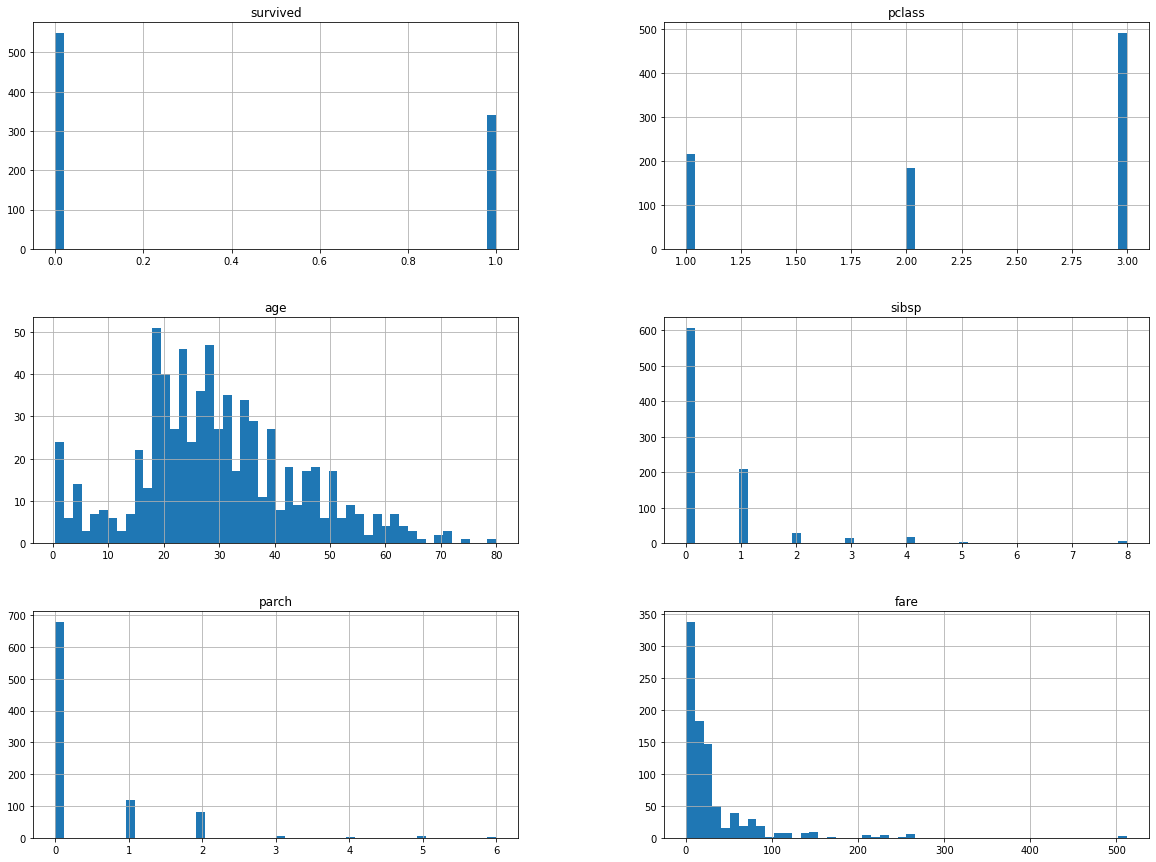

In [656]:
train_set.hist(bins=50, figsize=(20,15))
plt.show()

- Miehiä kyydissä melkein kaksinkertainen määrä naisiin verrattuna
- noin 18-vuotiaita kyydissä eniten
- Valtaosa matkusti ilman lähisukulaisia(parch/sibsp)
- 3 luokassa eniten matkustajia

### Scatter matrix

<AxesSubplot:xlabel='age', ylabel='survived'>

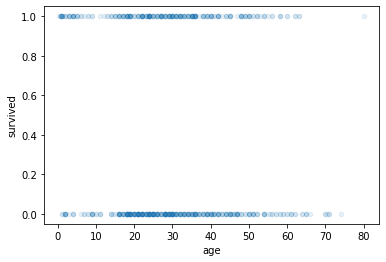

In [657]:
train_set.plot(kind="scatter", x="age", y="survived",
            alpha=0.1)

- alle 10-vuotiaista lapsista on pelastunut valtaosa
- Vanhimmat (70+) eivät lähtökohtaisesti selvinneet

In [658]:
corr_matrix = train_set.corr()
corr_matrix["survived"].sort_values(ascending=False)

survived    1.000000
fare        0.257307
parch       0.081629
sibsp      -0.035322
age        -0.077221
pclass     -0.338481
Name: survived, dtype: float64

<AxesSubplot:xlabel='age', ylabel='sex'>

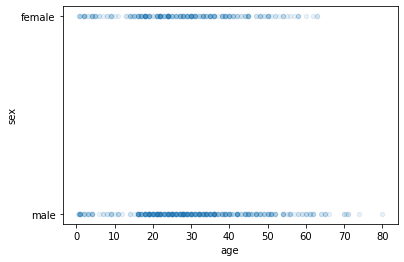

In [659]:
train_set.plot(kind="scatter", x="age", y="sex",
            alpha=0.1)

- Suurin osa miehistä noin 15-35 -vuotiaita
- Naisilla ikäjakauma on tasaisempi
- Vanhimmat matkustajat ovat miehiä

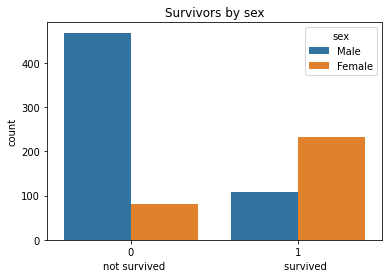

In [660]:
g = sns.countplot(x='survived', hue='sex', data=train_set).set(title= "Survivors by sex", xlabel= "not survived                                      survived")
plt.legend(title= "sex", loc= "upper right", labels=["Male", "Female"])
plt.show(g)

- Kuolleista valtaosa on miehiä

## täytetään embarked ja fare

Tarkastetaan mistä satamasta suurin osa on noussut kyytiin

In [661]:
print(train_set['embarked'].value_counts())
print(test_set['embarked'].value_counts())

S    644
C    168
Q     77
Name: embarked, dtype: int64
S    270
C    102
Q     46
Name: embarked, dtype: int64


S voittaa kirkkaasti, joten paikataan puuttuvat arvot sillä

In [662]:
train_set['embarked'].fillna(value='S', inplace=True)

Lasketaan faren keskiarvo ja paikataan puuttuva arvo sillä

In [663]:
test_set['fare'].fillna(value=test_set.fare.mean(), inplace=True)

## Täytetään age

In [664]:
keskiIka = (test_set.age.mean() + train_set.age.mean()) / 2
keskiIka

29.985854004252303

Keski-ikä on aika tarkka 30, joten täytetään sillä puuttuvat iät

In [665]:
train_set['age'].fillna(value=30, inplace=True)
test_set['age'].fillna(value=30, inplace=True)

## Poistetaan ylimääräiset tiedot

In [666]:
train_set.drop("cabin", axis=1, inplace=True)
test_set.drop("cabin", axis=1, inplace=True)

train_set.drop("ticket", axis=1, inplace=True)
test_set.drop("ticket", axis=1, inplace=True)

train_set.drop("name", axis=1, inplace=True)
test_set.drop("name", axis=1, inplace=True)

tarkastetaan muutos

In [667]:
print('\nNull Values in Training \n{}'.format(train_set.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_set.isnull().sum()))
train_set.head(1)


Null Values in Training 
survived    0
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

Null Values in Testing 
pclass      0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64


,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,male,22.0,1,0,7.25,S


## Korvataan merkkijonoarvot numeroilla

sex ja embark

In [668]:
luokat = {"female": 1, "male": 0}
train_set['sex'] = train_set['sex'].map(luokat)
test_set['sex'] = test_set['sex'].map(luokat)

luokat = {"S": 1, "C": 2, "Q": 3}
train_set['embarked'] = train_set['embarked'].map(luokat)
test_set['embarked'] = test_set['embarked'].map(luokat)

In [669]:
train_set.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked
0,0,3,0,22.0,1,0,7.2500,1
1,1,1,1,38.0,1,0,71.2833,2
2,1,3,1,26.0,0,0,7.9250,1
3,1,1,1,35.0,1,0,53.1000,1
4,0,3,0,35.0,0,0,8.0500,1


## Normalisoidaan data

In [670]:
LABEL = 'survived'
y = train_set[LABEL]
train_set_norm = train_set.drop(LABEL, axis=1)

scaler = MinMaxScaler()
scaled_train_set = scaler.fit_transform(train_set_norm)
scaled_test_set = scaler.fit_transform(test_set)

scaled_train_set = pd.DataFrame(scaled_train_set, columns=train_set_norm.columns, index=train_set_norm.index)
scaled_test_set = pd.DataFrame(scaled_test_set, columns=test_set.columns, index=test_set.index)

scaled_train_set.head()

,pclass,sex,age,sibsp,parch,fare,embarked
0,1.0,0.0,0.271174,0.125,0.0,0.014151,0.0
1,0.0,1.0,0.472229,0.125,0.0,0.139136,0.5
2,1.0,1.0,0.321438,0.000,0.0,0.015469,0.0
3,0.0,1.0,0.434531,0.125,0.0,0.103644,0.0
4,1.0,0.0,0.434531,0.000,0.0,0.015713,0.0


# Random forest regression model

In [671]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_set, y, test_size=0.2)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(712, 7) (179, 7)
(712,) (179,)


In [672]:
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

RandomForestClassifier()

### Karsitaan dataa lisää

In [673]:
karsittu_train_set = scaled_train_set.drop(['parch','embarked'], axis=1)
karsittu_test_set = scaled_test_set.drop(['parch','embarked'], axis=1)

### Ajetaan koulutus karsitulla datalla

Accuracy:  0.8435754189944135
-----------------classification report---------------
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       108
           1       0.80      0.80      0.80        71

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



,pclass,sex,age,sibsp,parch,fare,embarked,Survival_Predictions
0,3,0,34.5,0,0,7.8292,3,0
1,3,1,47.0,1,0,7.0000,1,0
2,2,0,62.0,0,0,9.6875,3,0
3,3,0,27.0,0,0,8.6625,1,0
4,3,1,22.0,1,1,12.2875,1,0


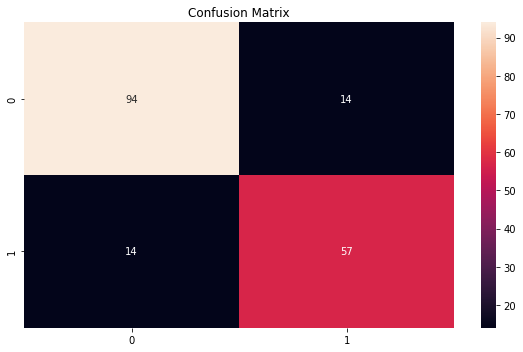

In [674]:
X_train, X_test, y_train, y_test = train_test_split(karsittu_train_set, y, test_size=0.2)
clf = RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))

print("-----------------classification report---------------")
print(classification_report(y_test,y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,5))
sns.heatmap(conf_matrix, annot=True)
plt.title('Confusion Matrix')
plt.tight_layout()

prediction = clf.predict(karsittu_test_set)

test_set['Survival_Predictions'] = pd.Series(prediction)
test_set.head()

# Luodaan palautustiedosto Kaggleen

### Muutetaan muotoon, jossa on vain passengerId ja Survived

In [675]:
submission_set = test_set

submission_set.drop(['pclass','sex','age','sibsp','parch','fare','embarked'], axis=1, inplace=True)

submission_set["PassengerId"] = [i for i in range(892,1310)]

submission_set["Survived"] = submission_set.pop("Survival_Predictions")



### Tallennetaan csv-tiedosto

In [677]:
# submission_set.to_csv('./submission.csv', index=False)

# Logistic regression model

In [678]:
X = scaled_train_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

In [679]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
y_pred

array([0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1], dtype=int64)

In [680]:
print("Accuracy score:", accuracy_score(y_pred, y_test))
confusion_matrix(y_pred, y_test)

Accuracy score: 0.7966101694915254


array([[155,  31],
       [ 29,  80]], dtype=int64)

# Lopputulos

- Molempien mallien tarkkuus, noin 80 - 84% oikein, oli meille oikein riittävä.
- Kagglen kilpailussa pyrimme 13 000 parhaimman joukkoon, joten oma sijoituksemme 12 920 ylitti odotuksemme.